<table align="left">
<td vertical-align="bottom">
<a target="_blank" align="center" href="https://stepup.ai/test_time_data_augmentation"><img height="32px" src="https://stepup.ai/favicon.png"/>Follow on stepup.ai</a>
</td>
<td>
 <a  target="_blank" href="https://colab.research.google.com/github/dufourpascal/stepupai/blob/master/tutorials/data_augmentation/test_time_data_augmentation.ipynb"><img style="margin-bottom:10px" src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
<a target="_blank" href="https://github.com/dufourpascal/stepupai/blob/master/tutorials/data_augmentation/test_time_data_augmentation.ipynb"><img style="margin-bottom:10px" class="invertable-logo" src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"/>View source on GitHub</a>
</td>
<td>
<a href="https://drive.google.com/file/d/1psZRB3HiK2HOGwvZD6nhXhzsq2YV0OA1/view?usp=sharing" download><img class="invertable-logo" style="margin-bottom:10px" src="https://www.tensorflow.org/images/download_logo_32px.png"/>Download notebook</a>
</td>
</table>

#Test time Data Augmentation in Keras
In this tutorial, we are going to look at test-time data augmentation, what it is and what it is not. We will train a Cifar10 classifier from scratch (without augmenting the training dataset) see how we can improve the accuracy by augmenting the test set!
Follow along on the [blog post](https://stepup.ai/test_time_data_augmentation) for descriptions and a detailed discussion!

# Setup

## Imports and Helper Functions
First we define the imports for tensorflow, keras and matplotlib.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import scipy as sp
from tqdm import tqdm

And we're going to define a helper function to plot the first few images in a dataset.

In [2]:
def visualize_data(images, categories=None, class_names=None):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for i in range(min(3 * 7, len(images))):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        if class_names and categories is not None:
            class_index = categories[i].argmax()
            plt.xlabel(class_names[class_index])
    plt.show()

## Load and Cifar10 Dataset
Now let's import the Cifar10 dataset and plot a few images along with their classes.

170500096/170498071 [==============================] - 5s 0us/step


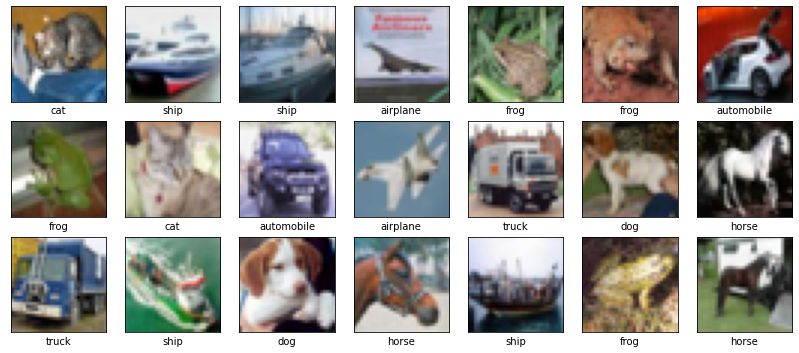

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
visualize_data(x_test, y_test, class_names)

# Classifier Training

To have a quick, reasonably performant model, we use transfer lerning on MobilenetV2.

In [4]:
def create_model():
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        pooling='avg',
        alpha=0.35,
        input_shape=(96,96,3),
        )
    base_model.trainable = False

    inputs = layers.Input(shape=(32, 32, 3), dtype= tf.uint8)
    x = tf.cast(inputs, tf.float32)
    x = preprocess_input(x)
    x = layers.UpSampling2D(size=(3,3), interpolation='nearest')(x)

    x = base_model(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x) 

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='CategoricalCrossentropy',
                  metrics=['accuracy']
                  )
    return model

Lets train the model for a few epochs.

In [5]:
batch_size = 32
epochs = 5
m = create_model()
m.summary()

history = m.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=1)

2023424/2019640 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_Cast (TensorFlow [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_0.35_96 (Functio (None, 1280)              410208    
_________________________________________________________

# Test-Time Augmentation Strategies

## Single Random Augmentation
This is how NOT to do it! If we simply augment the original image and show a single augmented test image, we cannot expect to reach higher accuracy!

313/313 [==============================] - 8s 26ms/step - loss: 0.6563 - accuracy: 0.7807


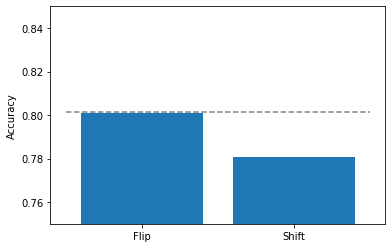

In [6]:
# accurayc without augmentation
_, acc = m.evaluate(x_test,  y_test)

# augmentation: random flip
datagen_flip = ImageDataGenerator(
    horizontal_flip=True)
datagen_flip.fit(x_test)

# augmentation: random shift
datagen_shift = ImageDataGenerator(
    width_shift_range=3. / 32.)
datagen_shift.fit(x_test)

# evaluate once with augmentation
_, acc_flip = m.evaluate(
    datagen_flip.flow(x_test, y_test, shuffle=False)) 
_, acc_shift = m.evaluate(
    datagen_shift.flow(x_test, y_test, shuffle=False)) 
                  
# plot the results
x = np.arange(2)
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.ylabel('Accuracy')
plt.bar(x, [acc_flip, acc_shift])
plt.plot([-0.5, 1.5], [acc, acc], '--', color='gray')
plt.xticks(x, ('Flip', 'Shift'))
plt.ylim(0.75, 0.85)
plt.show()

## Multiple Random Augmentations
This is also not ideal, but you see this in practice quite often! Here we run the prediction multiple times with random augmentations.

In [7]:
def agg_preds(predictions, y):
    y_classes = np.argmax(y, axis=1)
    acc_hist = []

    for i in range(predictions.shape[0]):
        pred_agg = np.mean(predictions[:i+1], axis=0)
        preds = np.argmax(pred_agg, axis=1)
        acc = preds == y_classes
        acc = np.mean(acc)
        acc_hist.append(acc)
    return acc_hist

def eval_random(model, datagen, x, y, epochs=4):
    datagen.fit(x)

    predictions = []
    acc_history = []

    prediction = model.predict(x)
    predictions.append(prediction)
    for i in range(epochs):
        prediction = model.predict(datagen.flow(x, shuffle=False))
        predictions.append(prediction)

    predictions = np.stack(predictions)
    acc_history = agg_preds(predictions, y)
    return acc_history

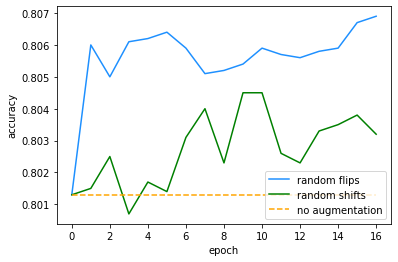

In [8]:
epochs = 16
acc_flip = eval_random(m, datagen_flip, x_test, y_test, epochs=epochs)
acc_shift = eval_random(m, datagen_shift, x_test, y_test, epochs=epochs)

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(acc_flip, label='random flips', color='dodgerblue')
plt.plot(acc_shift, label='random shifts', color='green')
plt.plot([acc] * len(acc_flip), '--',
         label='no augmentation', color='orange')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

## Multiple Predefined Augmentations
The way it should be implemented: Find a good set of augmentation parameters, then consistently use these parameters. No random augmentation is performed.

In [9]:
def flip_lr(images):
    return np.flip(images, axis=2)

def shift(images, shift, axis):
    return np.roll(images, shift, axis=axis)

def rotate(images, angle):
    return sp.ndimage.rotate(
        images, angle, axes=(1,2),
        reshape=False, mode='nearest')

In [10]:
pred = m.predict(x_test)

pred_f = m.predict(flip_lr(x_test))

pred_w0 = m.predict(shift(x_test, -3, axis=2))
pred_w1 = m.predict(shift(x_test, 3, axis=2))

pred_h0 = m.predict(shift(x_test, -3, axis=1))
pred_h1 = m.predict(shift(x_test, 3, axis=1))

pred_r0 = m.predict(rotate(x_test, -10))
pred_r1 = m.predict(rotate(x_test, 10))

In [11]:
def agg_acc(predictions, y):
    y_classes = np.argmax(y, axis=1)
    pred_agg = np.mean(predictions, axis=0)
    preds = np.argmax(pred_agg, axis=1)
    acc = np.mean(preds == y_classes)
    return acc

acc = agg_acc(np.expand_dims(pred, axis=0), y_test)

preds_f = np.stack((pred, pred_f))
acc_f = agg_acc(preds_f, y_test)

preds_w = np.stack((pred, pred_w0, pred_w1))
acc_w = agg_acc(preds_w, y_test)

preds_h = np.stack((pred, pred_h0, pred_h1))
acc_h = agg_acc(preds_h, y_test)

preds_hw = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1))
acc_hw = agg_acc(preds_hw, y_test)

preds_fhw = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f))
acc_fhw = agg_acc(preds_fhw, y_test)

preds_r = np.stack((pred, pred_r0, pred_r1))
acc_r = agg_acc(preds_r, y_test)

preds_fhwr = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f, pred_r0, pred_r1))
acc_fhwr = agg_acc(preds_fhwr, y_test)

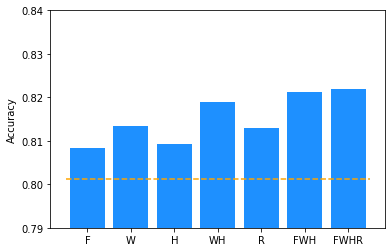

In [12]:
y = [acc_f,  acc_w, acc_h, acc_hw,
     acc_r, acc_fhw, acc_fhwr]

x = np.arange(len(y))
labels = ['F', 'W', 'H', 'WH', 'R','FWH', 'FWHR']

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.ylabel('Accuracy')
plt.bar(x, y, color='dodgerblue')
plt.plot([x[0]-0.5, x[-1]+0.5], [acc, acc],
         '--', color='orange')
plt.xticks(x, labels)
plt.ylim(0.79, 0.84)
plt.show()

Head over to the [blog post](https://stepup.ai/test_time_data_augmentation) for a detailed discussion and a list of best practices for test-time data augmentation!